In [1]:
import os
import json
import pysam
import gzip
import subprocess
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
from pyBioInfo.IO.File import BedFile, BamFile

/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


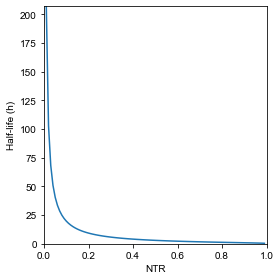

In [233]:
xs = np.arange(0, 1, 0.01)
ys = [-3/np.log2(1-x) for x in xs]
plt.figure(figsize=(4, 4))
plt.plot(xs, ys)
plt.xlim(0, 1)
plt.ylim(0, max(ys))
plt.xlabel("NTR")
plt.ylabel("Half-life (h)")
plt.tight_layout()
plt.show()

# Summary of isoforms per gene

--------------------------------------------------------------------------------
K562
0	3957	('protein_coding',)
1	575	('protein_coding', 'protein_coding')
2	164	('lncRNA',)
3	124	('protein_coding', 'protein_coding', 'protein_coding')
4	69	('processed_transcript', 'protein_coding')
5	64	('nonsense_mediated_decay', 'protein_coding')
6	56	('processed_transcript',)
7	54	('protein_coding', 'retained_intron')
8	30	('protein_coding', 'protein_coding', 'protein_coding', 'protein_coding')
9	22	('nonsense_mediated_decay', 'protein_coding', 'protein_coding')
--------------------------------------------------------------------------------
mESC
0	4833	('protein_coding',)
1	348	('protein_coding', 'protein_coding')
2	84	('processed_pseudogene',)
3	54	('protein_coding', 'protein_coding', 'protein_coding')
4	52	('protein_coding', 'retained_intron')
5	36	('processed_transcript',)
6	35	('lincRNA',)
7	30	('processed_transcript', 'protein_coding')
8	28	('nonsense_mediated_decay', 'protein_coding')
9	17	('

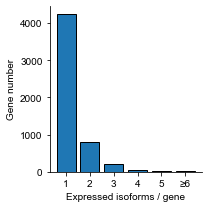

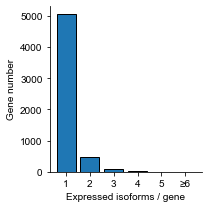

In [218]:
strains = ["K562", "mESC"]
for strain in strains:
    print("-" * 80)
    print(strain)
    df = pd.read_csv("../../1_NanoNASCseq/results/expression/report/isoform_based/%s.all_cells.min_read_2_min_tc_2.annotated.tsv" % strain, sep="\t", index_col=0)
    df = df[(df["TPM"] >= 10) & (df["Total"] >= 10)]
    counter = defaultdict(int)
    counter2 = defaultdict(int)
    for gid, tmp in df.groupby(by="GeneID"):
        counter[len(tmp)] += 1
        counter2[tuple(list(sorted((tmp["TranscriptType"]))))] += 1
    xs = np.array([1, 2, 3, 4, 5, 6])
    ticks = list(map(str, xs))
    ticks[-1] = "≥%s" % ticks[-1]
    ys = np.array([counter[x] for x in xs])
    ys[-1] = sum(counter.values()) - sum(ys[:-1])
    plt.figure(figsize=(3, 3))
    plt.bar(xs, ys, edgecolor="black")
    plt.xlabel("Expressed isoforms / gene")
    plt.ylabel("Gene number")
    plt.xticks(xs, ticks)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/expressed_isoforms_per_gene.%s.pdf" % strain, dpi=300)
    
    items = list(sorted(counter2.items(), key=lambda item: item[1], reverse=True))
    for i, (k, v) in enumerate(items[:10]):
        print(i, v, k, sep="\t")

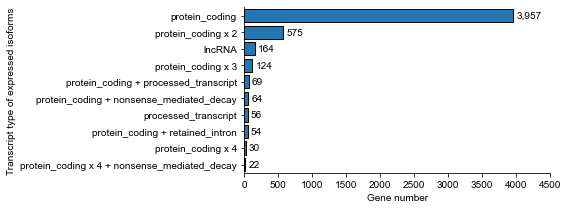

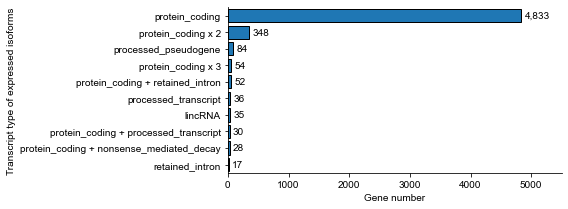

In [223]:
# K562
data1 = [
    [3957, "protein_coding"],
    [575, "protein_coding x 2"],
    [164, "lncRNA"],
    [124, "protein_coding x 3"],
    [69, "protein_coding + processed_transcript"],
    [64, "protein_coding + nonsense_mediated_decay"],
    [56, "processed_transcript"],
    [54, "protein_coding + retained_intron"],
    [30, "protein_coding x 4"],
    [22, "protein_coding x 4 + nonsense_mediated_decay"]
]

# mESC
data2 = [
    [4833, "protein_coding"],
    [348, "protein_coding x 2"],
    [84, "processed_pseudogene"],
    [54, "protein_coding x 3"],
    [52, "protein_coding + retained_intron"],
    [36, "processed_transcript"],
    [35, "lincRNA"],
    [30, "protein_coding + processed_transcript"],
    [28, "protein_coding + nonsense_mediated_decay"],
    [17, "retained_intron"]
]

for strain in strains:
    if strain == "K562":
        data = data1
        lim = 4500
    else:
        data = data2
        lim = 5500
    ys = np.arange(len(data))
    xs = [v[0] for v in data]
    ticks = [v[1] for v in data]
    plt.figure(figsize=(8, 3))
    plt.barh(ys, xs, edgecolor="black")
    for x, y in zip(xs, ys):
        plt.text(x + lim * 0.01, y, "%s" % format(x, ","), va="center")
    plt.xlim(0, lim)
    plt.ylim(max(ys) + 0.5, min(ys) - 0.5)
    plt.xlabel("Gene number")
    plt.ylabel("Transcript type of expressed isoforms")
    plt.yticks(ys, ticks)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/transcript_type_combination.%s.pdf" % strain, dpi=300)

# Difference in NTR and half-life

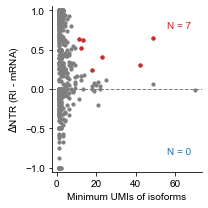

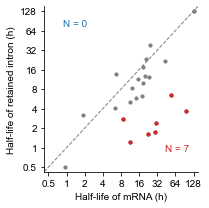

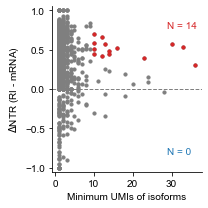

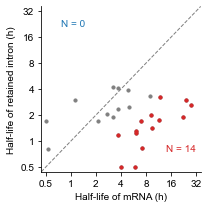

In [16]:
# mRNA and retained_intron

def correct_halflife(time, ntrs, tmin, tmax):
    hts = []
    for ntr in ntrs:
        if ntr == 0:
            hts.append(tmax)
        elif ntr == 1:
            hts.append(tmin)
        else:
            ht = -time/np.log2(1-ntr)
            ht = max(min(ht, tmax), tmin)
            hts.append(ht)
    return hts

strains = ["K562", "mESC"]

for strain in strains:
    infile = "../../1_NanoNASCseq/results/expression/report/isoform_based/%s.treatment_cells.min_read_2_min_tc_2.annotated.tsv" % strain
    outfile = "results/isoform_ntr_diff.mRNA_RI.%s.tsv" % strain
    if not os.path.exists(outfile):
        dat = pd.read_csv(infile, sep="\t", index_col=0)
        rows = []
        for gid, tmp in dat.groupby(by="GeneID"):
            tmp = tmp[tmp["Total"] > 0]
            ttypes = list(tmp["TranscriptType"])
            if "protein_coding" in ttypes and "retained_intron" in ttypes:
                tmp = tmp.sort_values(by="Total", ascending=False)
                tid1, ttype1, total1, nascent1, t1 = None, None, None, None, None
                tid2, ttype2, total2, nascent2, t2 = None, None, None, None, None
                for tid, ttype, total, nascent, t in zip(tmp.index, tmp["TranscriptType"], tmp["Total"], tmp["Nascent"], tmp["T"]):
                    if ttype == "protein_coding":
                        tid1, ttype1, total1, nascent1, t1 = tid, ttype, total, nascent, t
                        break
                for tid, ttype, total, nascent, t in zip(tmp.index, tmp["TranscriptType"], tmp["Total"], tmp["Nascent"], tmp["T"]):
                    if ttype == "retained_intron":
                        tid2, ttype2, total2, nascent2, t2 = tid, ttype, total, nascent, t
                        break
                pval = fisher_exact([[total1 - nascent1, nascent1], [total2 - nascent2, nascent2]])[1]
                row = [gid,
                       tid1, ttype1, total1, nascent1, nascent1/total1, t1,
                       tid2, ttype2, total2, nascent2, nascent2/total2, t2, 
                       pval]
                rows.append(row)
        m = pd.DataFrame(rows, columns=["GeneID", 
                                        "TranscriptID1", "TranscriptType1", "Total1", "Nascent1", "NTR1", "T1",
                                        "TranscriptID2", "TranscriptType2", "Total2", "Nascent2", "NTR2", "T2", 
                                        "Pvalue"])
        m["Total.Min"] = m[["Total1", "Total2"]].min(axis=1)
        m["NTR.Diff"] = m["NTR2"] - m["NTR1"]
        m.to_csv(outfile, sep="\t", index=False)
    
    if True:
        m = pd.read_csv(outfile, sep="\t", header=0)
        m1 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] > 0.1) & (m["Pvalue"] < 0.05)]
        m2 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] < -0.1) & (m["Pvalue"] < 0.05)]
        xs, ys = m["Total.Min"], m["NTR.Diff"]
        xs1, ys1 = m1["Total.Min"], m1["NTR.Diff"]
        xs2, ys2 = m2["Total.Min"], m2["NTR.Diff"]

        plt.figure(figsize=(3, 3)) 
        s = 10
        plt.scatter(xs, ys, marker="o", s=s, color="C7", clip_on=False)
        plt.scatter(xs1, ys1, marker="o", s=s, color="C3", clip_on=False)
        plt.scatter(xs2, ys2, marker="o", s=s, color="C0", clip_on=False)
        plt.axhline(0, lw=1, ls="--", color="grey")
        plt.xlabel("Minimum UMIs of isoforms")
        plt.ylabel("$\Delta$NTR (RI - mRNA)")
        plt.ylim(-1.05, 1.05)
        plt.yticks([-1, -0.5, 0, 0.5, 1])
        xmax = max(xs)
        plt.text(xmax * 0.8, 0.8, "N = %d" % len(xs1), color="C3", va="center")
        plt.text(xmax * 0.8, -0.8, "N = %d" % len(xs2), color="C0", va="center")
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.tight_layout()
        plt.savefig("figures/isoform_ntr_diff.mRNA_RI.%s.pdf" % strain, dpi=300)
    
    if True:
        m = pd.read_csv(outfile, sep="\t", header=0)
        if strain == "K562":
            x1, x2 = -1, 7
        else:
            x1, x2 = -1, 5
        w = x2 - x1
        
        m = m[m["Total.Min"] >= 10]
        m["T1"] = correct_halflife(3, m["NTR1"], 2**x1, 2**x2)
        m["T2"] = correct_halflife(3, m["NTR2"], 2**x1, 2**x2)
        m1 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] > 0.1) & (m["Pvalue"] < 0.05)]
        m2 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] < -0.1) & (m["Pvalue"] < 0.05)]
        # m1 = m[(m["T1"] > m["T2"]) & (m["Pvalue"] < 0.05)]
        # m2 = m[(m["T2"] > m["T1"]) & (m["Pvalue"] < 0.05)]
        if True:
            xs, ys = np.log2(m["T1"]), np.log2(m["T2"])
            xs1, ys1 = np.log2(m1["T1"]), np.log2(m1["T2"])
            xs2, ys2 = np.log2(m2["T1"]), np.log2(m2["T2"])
        else:
            xs, ys = m["T1"], m["T2"]
            xs1, ys1 = m1["T1"], m1["T2"]
            xs2, ys2 = m2["T1"], m2["T2"]
        s = 10
        plt.figure(figsize=(3, 3))
        plt.scatter(xs, ys, s=s, color="grey", clip_on=False)
        plt.scatter(xs1, ys1, s=s, color="C3", clip_on=False)
        plt.scatter(xs2, ys2, s=s,color="C0", clip_on=False)
        plt.text(x1 + w * 0.8, x1 + w * 0.1, "N = %d" % len(m1), color="C3")
        plt.text(x1 + w * 0.1, x1 + w * 0.9, "N = %d" % len(m2), color="C0")
        plt.plot([x1 - w * 0.03, x2 + w * 0.03], [x1 - w * 0.03, x2 + w * 0.03], lw=1, ls="--", color="grey")
        plt.xlim(x1 - w * 0.03, x2 + w * 0.03)
        plt.ylim(x1 - w * 0.03, x2 + w * 0.03)
        plt.xlabel("Half-life of mRNA (h)")
        plt.ylabel("Half-life of retained intron (h)")
        vs = np.arange(x1, x2 + 1)
        plt.xticks(vs, [2**int(v) for v in vs])
        plt.yticks(vs, [2**int(v) for v in vs])
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.tight_layout()
        plt.savefig("figures/isoform_halflife_diff.mRNA_RI.%s.pdf" % strain, dpi=300)
    
    # break

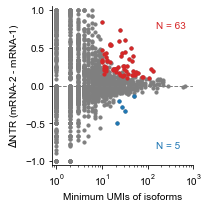

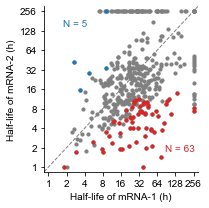

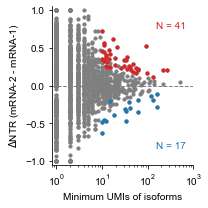

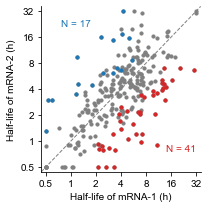

In [15]:
# mRNA and mRNA

strains = ["K562", "mESC"]

for strain in strains:
    infile = "../../1_NanoNASCseq/results/expression/report/isoform_based/%s.treatment_cells.min_read_2_min_tc_2.annotated.tsv" % strain
    outfile = "results/isoform_ntr_diff.mRNA.%s.tsv" % strain
    
    if not os.path.exists(outfile):
        dat = pd.read_csv(infile, sep="\t", index_col=0)
        rows = []
        for gid, tmp in dat.groupby(by="GeneID"):
            tmp = tmp[(tmp["Total"] > 0) & (tmp["TranscriptType"] == "protein_coding")]
            if len(tmp) < 2:
                continue
            tmp = tmp.sort_values(by="Total", ascending=False)
            r1 = tmp.iloc[0]
            r2 = tmp.iloc[1]
            tid1, ttype1, total1, nascent1, t1 = r1.name, r1["TranscriptType"], r1["Total"], r1["Nascent"], r1["T"]
            tid2, ttype2, total2, nascent2, t2 = r2.name, r2["TranscriptType"], r2["Total"], r2["Nascent"], r2["T"]
            pval = fisher_exact([[total1 - nascent1, nascent1], [total2 - nascent2, nascent2]])[1]
            row = [gid,
                   tid1, ttype1, total1, nascent1, nascent1/total1, t1,
                   tid2, ttype2, total2, nascent2, nascent2/total2, t2, 
                   pval]
            rows.append(row)
        m = pd.DataFrame(rows, columns=["GeneID", 
                                        "TranscriptID1", "TranscriptType1", "Total1", "Nascent1", "NTR1", "T1",
                                        "TranscriptID2", "TranscriptType2", "Total2", "Nascent2", "NTR2", "T2", 
                                        "Pvalue"])
        m["Total.Min"] = m[["Total1", "Total2"]].min(axis=1)
        m["NTR.Diff"] = m["NTR2"] - m["NTR1"]
        m.to_csv(outfile, sep="\t", index=False)
    
    if True:
        m = pd.read_csv(outfile, sep="\t", header=0)
        m1 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] > 0.1) & (m["Pvalue"] < 0.05)]
        m2 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] < -0.1) & (m["Pvalue"] < 0.05)]
        xs, ys = m["Total.Min"], m["NTR.Diff"]
        xs1, ys1 = m1["Total.Min"], m1["NTR.Diff"]
        xs2, ys2 = m2["Total.Min"], m2["NTR.Diff"]

        plt.figure(figsize=(3, 3)) 
        s = 10
        plt.scatter(xs, ys, marker="o", s=s, color="C7", clip_on=False)
        plt.scatter(xs1, ys1, marker="o", s=s, color="C3", clip_on=False)
        plt.scatter(xs2, ys2, marker="o", s=s, color="C0", clip_on=False)
        plt.text(150, 0.8, "N = %d" % len(xs1), color="C3", va="center")
        plt.text(150, -0.8, "N = %d" % len(xs2), color="C0", va="center")
        plt.axhline(0, lw=1, ls="--", color="grey")
        plt.xlabel("Minimum UMIs of isoforms")
        plt.ylabel("$\Delta$NTR (mRNA-2 - mRNA-1)")
        plt.xscale("log")
        plt.xlim(0.8, 1000)
        plt.ylim(-1.05, 1.05)
        plt.yticks([-1, -0.5, 0, 0.5, 1])
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.tight_layout()
        plt.savefig("figures/isoform_ntr_diff.mRNA.%s.pdf" % strain, dpi=300)
        # plt.close()
    
    if True:
        m = pd.read_csv(outfile, sep="\t", header=0)
        if strain == "K562":
            x1, x2 = 0, 8
        else:
            x1, x2 = -1, 5
        w = x2 - x1
        
        m = m[m["Total.Min"] >= 10]
        m["T1"] = correct_halflife(3, m["NTR1"], 2**x1, 2**x2)
        m["T2"] = correct_halflife(3, m["NTR2"], 2**x1, 2**x2)
        m1 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] > 0.1) & (m["Pvalue"] < 0.05)]
        m2 = m[(m["Total.Min"] >= 10) & (m["NTR.Diff"] < -0.1) & (m["Pvalue"] < 0.05)]
        xs, ys = np.log2(m["T1"]), np.log2(m["T2"])
        xs1, ys1 = np.log2(m1["T1"]), np.log2(m1["T2"])
        xs2, ys2 = np.log2(m2["T1"]), np.log2(m2["T2"])
        s = 10
        plt.figure(figsize=(3, 3))
        plt.scatter(xs, ys, s=s, color="grey", clip_on=False)
        plt.scatter(xs1, ys1, s=s, color="C3", clip_on=False)
        plt.scatter(xs2, ys2, s=s,color="C0", clip_on=False)
        plt.text(x1 + w * 0.8, x1 + w * 0.1, "N = %d" % len(m1), color="C3")
        plt.text(x1 + w * 0.1, x1 + w * 0.9, "N = %d" % len(m2), color="C0")
        plt.plot([x1 - w * 0.03, x2 + w * 0.03], [x1 - w * 0.03, x2 + w * 0.03], lw=1, ls="--", color="grey")
        plt.xlim(x1 - w * 0.03, x2 + w * 0.03)
        plt.ylim(x1 - w * 0.03, x2 + w * 0.03)
        plt.xlabel("Half-life of mRNA-1 (h)")
        plt.ylabel("Half-life of mRNA-2 (h)")
        vs = np.arange(x1, x2 + 1)
        plt.xticks(vs, [2**int(v) for v in vs])
        plt.yticks(vs, [2**int(v) for v in vs])
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.tight_layout()
        plt.savefig("figures/isoform_halflife_diff.mRNA.%s.pdf" % strain, dpi=300)
    # break

# Decay rate diversity transcript model

In [98]:
d = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")
d = d[(d["Strain"] == "K562") & (d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 5000)]
print("Cells:", len(d))

bamfile1 = "results/NanoNASCseq.K562.0uM3h.min_read_2.rmdup.bam"
bamfile2 = "results/NanoNASCseq.K562.0uM3h.min_read_2.rmdup.sorted.bam"
if not os.path.exists(bamfile2):
    fw = None
    for run, cell in d[["Run", "Cell"]].values:
        path = "../../1_NanoNASCseq/results/mapping/marked_duplicate/%s/%s_rmdup.bam" % (run, cell)
        with pysam.AlignmentFile(path) as f:
            if fw is None:
                fw = pysam.AlignmentFile(bamfile1, "wb", f)
            for s in f:
                if s.get_tag("CS") >= 2 and not s.is_duplicate:
                    fw.write(s)
    fw.close()

    cmd1 = "samtools sort -@ 4 -o %s %s" % (bamfile2, bamfile1)
    cmd2 = "samtools index -@ 4 %s" % bamfile2
    subprocess.check_call(cmd1, shell=True)
    subprocess.check_call(cmd2, shell=True)
    os.remove(bamfile1)

Cells: 190


In [17]:
with BedFile("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.transcripts.bed.gz") as f:
    transcripts = {t.name: t for t in f}

2253116 2268397
2252500 2269000 2500
76048050 76067508
76047500 76068800 5000


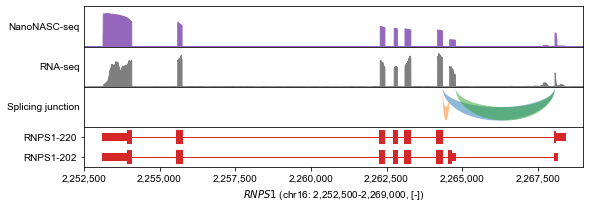

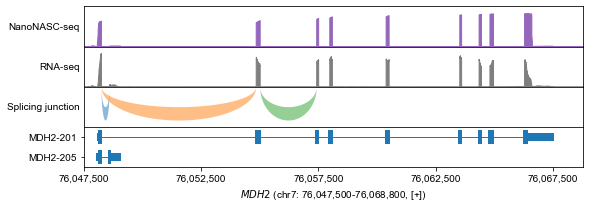

In [23]:
def get_coverages(path, chrom, start, end):
    covs = np.zeros(end - start)
    with BamFile(path) as f:
        for item in f.fetch(chrom, start, end):
            if item.segment.is_duplicate:
                continue
            for block_start, block_end in item.blocks:
                for idx in range(block_start - start, block_end - start):
                    if 0 <= idx < len(covs):
                        covs[idx] += 1  
    return covs

def plot_tracks(gname, tids, tnames, chrom, start, end, step, strand, junctions):
    bams = [
        "results/NanoNASCseq.K562.0uM3h.min_read_2.rmdup.sorted.bam",
        "../../4_RNAseq_ActD/results/mapping/rmdup/20221128_K562_Actd_0h_rep1.human.bam"]
    covs_list = [get_coverages(path, chrom, start, end) for path in bams]
    
    if False:
        for covs in covs_list:
            plt.figure(figsize=(8, 2))
            xs = np.arange(start, end)
            plt.plot(xs, covs)
            plt.tight_layout()
            plt.show()
            plt.close()
        
    nrow = 4
    fig, axs = plt.subplots(nrow, 1, figsize=(8.3, 3), sharex=True, gridspec_kw={"hspace": 0})

    labels = ["NanoNASC-seq", "RNA-seq"]
    colors = ["C4", "C7"]
    for i, covs in enumerate(covs_list[:2]):
        ax = axs[i]
        plt.sca(ax)
        xs = np.arange(start, end)
        ys = covs
        plt.fill_between(xs, ys, color=colors[i])
        plt.ylim(0, max(ys) * 1.2)
        plt.ylabel(labels[min(i, 1)], rotation=0, va="center", ha="right")
        plt.yticks([])

    ax = axs[nrow - 2]
    plt.sca(ax)
    plt.ylabel("Splicing junction", rotation=0, va="center", ha="right")
    plt.yticks([])
    plt.ylim(-0.6, 0)
    
    # plot splicing junction
    def get_ellipse_xy(s, e, b):
        center = (s + e) / 2
        a = (e - s) / 2
        a2 = a**2
        b2 = b**2
        c2 = a2 - b2
        xs = np.arange(s, e, 0.1)
        xs1 = xs - center
        x2 = xs1**2
        ys = (1 - x2 / a2) * b2
        ys = -np.power((1 - x2 / a2) * b2, 0.5)
        return xs, ys

    if True:
        for i, (s, e) in enumerate(junctions):
            xs1, ys1 = get_ellipse_xy(s, e, 0.3)
            xs2, ys2 = get_ellipse_xy(s, e, 0.5)
            plt.fill_between(xs1, ys1, ys2, alpha=0.5, lw=0, color="C%d" % i)

    ax = axs[nrow - 1]
    plt.sca(ax)
    exons = []
    cds = []
    color = "C0" if strand == "+" else "C3"
    for i, tid in enumerate(tids):
        y = -i
        transcript = transcripts[tid]
        # line
        length = transcript.end - transcript.start
        plt.plot([transcript.start, transcript.end], [y, y], lw=1, color=color)

        # exon
        for block_start, block_end in transcript.blocks:
            x = (block_start + block_end) / 2
            w = block_end - block_start # width
            h = 0.3 # height
            b = y - h / 2 # bottom
            exons.append([x, h, w, b])

        # cds
        if transcript.thick:
            thick_start, thick_end = transcript.thick
            for block_start, block_end in transcript.blocks:
                start1 = max(block_start, thick_start)
                end1 = min(block_end, thick_end)
                if start1 < end1:
                    x = (start1 + end1) / 2
                    w = end1 - start1
                    h = 0.6
                    b = y - h / 2
                    cds.append([x, h, w, b])
    
    # plot exons
    plt.bar([item[0] for item in exons], 
            [item[1] for item in exons], 
            width=[item[2] for item in exons], 
            bottom=[item[3] for item in exons], 
            edgecolor=color, lw=2,
            color=color)

    # plot cds
    plt.bar([item[0] for item in cds], 
            [item[1] for item in cds], 
            width=[item[2] for item in cds], 
            bottom=[item[3] for item in cds], 
            edgecolor=color, lw=2,
            color=color)

    plt.ylim(-1.5, 0.5)
    plt.yticks([0, -1], tnames)
    plt.xlim(start, end)
    xs = np.arange(start, end + 1, step)
    plt.xticks(xs, [format(x, ",") for x in xs])
    plt.xlabel("$\it{%s}$ (%s: %s-%s, [%s])" % (gname, chrom, format(start, ","), format(end, ","), strand))

    plt.tight_layout()
    plt.savefig("figures/gene_model.%s.pdf" % gname, dpi=300)
    
# RNPS1
gname = "RNPS1"
tids = ["ENST00000566458.5", "ENST00000320225.10"]
tnames = ["RNPS1-220", "RNPS1-202"]
chrom = transcripts[tids[0]].chrom
strand = "-"
min_start = min(transcripts[tids[0]].start, transcripts[tids[1]].start)
max_end = max(transcripts[tids[0]].end, transcripts[tids[1]].end)
print(min_start, max_end)
start, end = 2252500, 2269000
step = 2500
print(start, end, step)
junctions = [
    [2264331, 2268054],
    [2264331, 2264572],
    [2264760, 2268054]
]
plot_tracks(gname, tids, tnames, chrom, start, end, step, strand, junctions)

# MDH2
gname = "MDH2"
tids = ["ENST00000315758.10", "ENST00000461263.2"]
tnames = ["MDH2-201", "MDH2-205"]
chrom = transcripts[tids[0]].chrom
strand = "+"
min_start = min(transcripts[tids[0]].start, transcripts[tids[1]].start)
max_end = max(transcripts[tids[0]].end, transcripts[tids[1]].end)
print(min_start, max_end)
start, end = 76047500, 76068800
step = 5000
print(start, end, step)
junctions = [
    [76048226, 76048575],
    [76048226, 76054829],
    [76054998, 76057409]
]
plot_tracks(gname, tids, tnames, chrom, start, end, step, strand, junctions)

## Validation of decay rate diversity by NGS

In [123]:
factors = json.load(open("../../4_RNAseq_ActD/results/conversion_factors.20221128.json"))

samples = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]
columns = samples

def get_junction_reads(path, chrom, start, end):
    with pysam.AlignmentFile(path) as f:
        d = f.find_introns(f.fetch(chrom, start, end))
        return d[(start, end)] 

In [45]:
# RPLP1 (discard)
gene_name = "RPLP1"
chrom = "chr15"
introns = [
    (69453020, 69455169),
    (69453020, 69453646),
    (69453721, 69455169)]

In [124]:
# RBPS1
gene_name = "RBPS1"
chrom = "chr16"
introns = [
    (2264331, 2268054),
    (2264331, 2264572),
    (2264760, 2268054)]

In [88]:
# MDH2
gene_name = "MDH2"
chrom = "chr7"
introns = [
    (76048226, 76048575),
    #(76048226, 76057409),
    (76048226, 76054829),
    (76054998, 76057409)]

In [125]:
paths = [
    "../../4_RNAseq_ActD/results/mapping/rmdup/20221128_K562_Actd_0h_rep1.hg.bam",
    "../../4_RNAseq_ActD/results/mapping/rmdup/20221128_K562_Actd_0h_rep2.hg.bam",
    "../../4_RNAseq_ActD/results/mapping/rmdup/20221128_K562_Actd_3h_rep1.hg.bam",
    "../../4_RNAseq_ActD/results/mapping/rmdup/20221128_K562_Actd_3h_rep2.hg.bam",
    "../../4_RNAseq_ActD/results/mapping/rmdup/20221128_K562_Actd_6h_rep1.hg.bam",
    "../../4_RNAseq_ActD/results/mapping/rmdup/20221128_K562_Actd_6h_rep2.hg.bam"]
rows = []
for start, end in introns:
    row = []
    for path in paths:
        n = get_junction_reads(path, chrom, start, end)
        row.append(n)
    rows.append(row)
d = pd.DataFrame(rows)
d.columns = samples

for sample in samples:
    x = factors["%s,%s" % (sample, "0h-1")]
    d["%s_adj" % sample] = d[sample] * x
for sample in samples:
    d["%s_adj_p" % sample] = d["%s_adj" % sample] / d[["0h-1_adj", "0h-2_adj"]].mean(axis=1)

df = d
Ts = []
Ds = []
for vs in df[[c + "_adj_p" for c in columns]].values:
    xs0 = [0, 0, 3, 3, 6, 6]
    ys0 = vs
    ys = ys0[2:]
    xs = np.array([3, 3, 6, 6])
    Y = np.log2(-np.log2(ys))
    X = np.log2(xs)
    b = sum(Y - X) / len(Y)
    T = 1 / (2 ** b)
    D = sum([abs(y - 2 ** (-x/T)) for x, y in zip(xs0, ys0)])
    Ts.append(T)
    Ds.append(D)
df["T"] = Ts
df["D"] = Ds
d = df

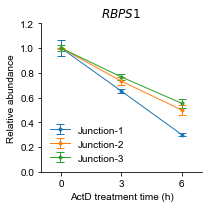

In [126]:
labels = ["Junction-%d" % (i + 1) for i in range(len(d))] # MDH2
colors = ["C0", "C1", "C2", "C3"]
xs = [0, 0, 3, 3, 6, 6]
plt.figure(figsize=(3, 3))
plt.title("$\it{%s}$" % gene_name)    
for i in range(len(d)):
    ys = [d["%s_adj_p" % sample].values[i] for sample in samples]    
    m = np.array(ys).reshape(3, -1)
    ys1 = np.mean(m, axis=1)
    yerr1 = np.std(m, axis=1)
    xs1 = [0, 3, 6]
    plt.errorbar(xs1, ys1, yerr=yerr1, marker=".", label=labels[i], capsize=4, capthick=1, lw=1)
# plt.text(0, 0.2, "$\it{%s}$" % gene_name)    
plt.ylim(0, 1.2)
plt.xlabel("ActD treatment time (h)")
plt.ylabel("Relative abundance")
plt.xticks([0, 3, 6])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(frameon=False)
plt.xlim(-1, 7)
plt.tight_layout()
plt.savefig("figures/validation_of_decay_by_ngs.%s.pdf" % gene_name, dpi=300)